# Audio Classification Using Deep Learning

## 2. Data Splitting and Feature Extraction

### Data splitting

In machine learning algorithm development, it is crucial to split the dataset into separate distinct sets for training and evaluation. This is to make sure that the model is properly evaluated on the unseen data (not used during training) in an attempt to have a model that is generalised well on the new data. The common approach is to divide the dataset into three parts: training set, validation set, and testing set. The training set is used to train the model (i.e. obtain the weights); the validation set is used to optimise the hyperparemters of model; the testing set is used for final evaluation of the model. In this project, I use 80% for training set, 10% for validation set, and 10% for testing set. The function used to perform data splitting is split_data_index within preprocessing module.

We iteratively split the data per class (corresponding to directory) and store the filenames and their associated class names into dataframe/tabular file (.csv). The codes for splitting the dataset is given below.

In [5]:
import os
import numpy as np
import glob
import pandas as pd
from preprocessing import split_data_index
from utils import flatten

dir_name = "data" # directory name containing the dataset
# list of class (i.e. label) names
label_names = [label for label in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name,label))]
# sort the label names alphabetically
label_names.sort()

# split data into training, validation, and testing tests
train_files = []
valid_files = []
test_files = []

train_labels = []
valid_labels = []
test_labels = []
for label in label_names:
    file_names = os.path.join(dir_name,label,"*.wav")
    file_lists = np.asarray(glob.glob(file_names))
    file_idxs = np.arange(len(file_lists))
    train_idx,valid_idx,test_idx = split_data_index(file_idxs,train_size=0.8,valid_size=0.1)
    # append training, validation, and testing lists of files
    train_files.append(file_lists[train_idx].tolist())
    valid_files.append(file_lists[valid_idx].tolist())
    test_files.append(file_lists[test_idx].tolist())
    # append training, validation, and testing lists of files
    train_labels.append([label]*len(train_idx))
    valid_labels.append([label]*len(valid_idx))
    test_labels.append([label]*len(test_idx))

train_files = flatten(train_files)
valid_files = flatten(valid_files)
test_files = flatten(test_files)
train_labels = flatten(train_labels)
valid_labels = flatten(valid_labels)
test_labels = flatten(test_labels)

df_train = pd.DataFrame(list(zip(train_files,train_labels)),columns =['Training Files', 'Training Labels'])        
df_valid = pd.DataFrame(list(zip(valid_files,valid_labels)),columns =['Validation Files', 'Validation Labels'])   
df_test = pd.DataFrame(list(zip(test_files,test_labels)),columns =['Testing Files', 'Testing Labels'])   

# store training, validation, and testing sets into files
print("Storing the training, validation, and training sets into .csv files")
df_train.to_csv("training.csv")
df_valid.to_csv("validation.csv")
df_test.to_csv("testing.csv")

Storing the training, validation, and training sets into .csv files


### Feature extraction

After splitting the dataset, we next perform feature extraction from each file within training, validation, and testing sets. Audio signal can be represented in time, frequency, or time-frequency which can be illustrated by the following image: 
<img src="https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png">

In this project, we will use two commonly used features:
* Mel power spectrogram. We use 40 number of Mel bands
* Mel frequency cepstral coefficient (MFCC). We use 40 number of MFCCs.

We use Librosa functions to extract these features from raw audio signal. The examples of extracted features from five different classes are shown below.


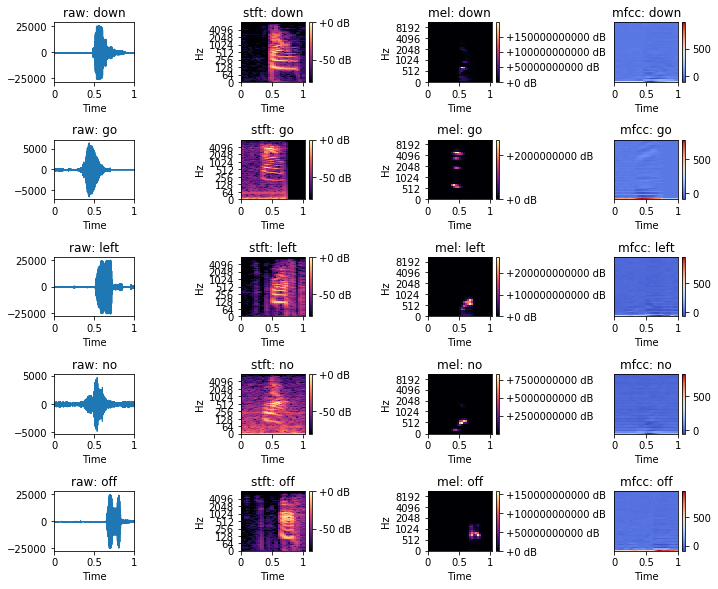

In [8]:
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
from preprocessing import pad_input, extract_stft, extract_mel, extract_mfcc, normalise_feature

label_plots = []
for label in label_names:
    file_names = os.path.join(dir_name,label,"*.wav")
    file_lists = glob.glob(file_names)
    label_plots.append(file_lists[0])

audio_plots = []
for i,file in enumerate(label_plots):
    sr, audio = wavfile.read(file)
    audio_plots.append(pad_input(audio))
    
title_plots = ['raw','stft','mel','mfcc']
nrow = len(audio_plots)
ncol = len(title_plots)
fig = plt.figure(figsize=(10,16))
for r in range(5):
    plt.subplot(nrow,ncol,ncol*r+1)
    librosa.display.waveplot(audio_plots[r], sr=sr)
    plt.title("{}: {}".format(title_plots[0],label_names[r]))
    plt.xlim(0,1)
    plt.locator_params(axis='x', nbins=3)
    # stft spectrogram
    stft = extract_stft(audio_plots[r])
    plt.subplot(nrow,ncol,ncol*r+2)
    librosa.display.specshow(stft,x_axis='time',y_axis='log',sr=sr)
    plt.title("{}: {}".format(title_plots[1],label_names[r]))
    plt.locator_params(axis='x', nbins=3)
    plt.colorbar(format='%+2.0f dB')
    # mel spectrogram
    mel = extract_mel(audio_plots[r])
    plt.subplot(nrow,ncol,ncol*r+3)
    librosa.display.specshow(mel,x_axis='time',y_axis='mel',sr=sr)
    plt.title("{}: {}".format(title_plots[2],label_names[r]))
    plt.locator_params(axis='x', nbins=3)
    plt.colorbar(format='%+02.0f dB')
    # mfcc
    plt.subplot(nrow,ncol,ncol*r+4)
    mfcc = extract_mfcc(audio_plots[r])
    librosa.display.specshow(mfcc,x_axis='time',sr=sr)
    plt.title("{}: {}".format(title_plots[3],label_names[r]))
    plt.xlim(0,1)
    plt.locator_params(axis='x', nbins=3)
    plt.colorbar()
plt.tight_layout()

### Store the features

To speed up the model training, we precompute all the featues and store them into hdf files. We normalise the features using z-score (zero mean and unit variance) before being fed to the deep learning model.

In [10]:
import h5py
from utils import change_label, make_dir

# open training, validation, and testing sets from csv files
train_csv = pd.read_csv("training.csv",index_col=0)
valid_csv = pd.read_csv("validation.csv",index_col=0)
test_csv = pd.read_csv("testing.csv",index_col=0)

feature_dir = 'features' # directory to store the extracted features
make_dir(feature_dir) # create directory if it does not exist

mel_train = []
mel_valid = []
mel_test = []

mfcc_train = []
mfcc_valid = []
mfcc_test = []

change = change_label() # to encode string label (class name) into binary matrix or vice versa

for i in range(train_csv.shape[0]):
    sr, audio = wavfile.read(train_csv.iloc[i,0])
    audio = pad_input(audio)
    mel = normalise_feature(extract_mel(audio))
    mfcc = normalise_feature(extract_mfcc(audio))
    mel_train.append(mel.T)
    mfcc_train.append(mfcc.T)
mel_train = np.asarray(mel_train)
mfcc_train = np.asarray(mfcc_train)
y = train_csv.iloc[:,1].to_list()
y_train = change.str2bin(y)
train_file = os.path.join(feature_dir,'mel_mfcc_train.h5')
print ("Storing extracted features and associated label from training set into a file: "+train_file)
with h5py.File(train_file,'w') as f:
    f['mel_train'] = mel_train
    f['mfcc_train'] = mfcc_train
    f['y_train'] = y_train

for i in range(valid_csv.shape[0]):
    sr, audio = wavfile.read(valid_csv.iloc[i,0])
    audio = pad_input(audio)
    mel = normalise_feature(extract_mel(audio))
    mfcc = normalise_feature(extract_mfcc(audio))
    mel_valid.append(mel.T)
    mfcc_valid.append(mfcc.T)
mel_valid = np.asarray(mel_valid)
mfcc_valid = np.asarray(mfcc_valid)
y = valid_csv.iloc[:,1].to_list()
y_valid = change.str2bin(y)
valid_file = os.path.join(feature_dir,'mel_mfcc_valid.h5')
print ("Storing extracted features and associated label from validation set into a file: "+valid_file)
#with open(valid_file, 'wb') as f:
#    pickle.dump([mel_valid, mfcc_valid, y_valid], f)
with h5py.File(valid_file,'w') as f:
    f['mel_valid'] = mel_valid
    f['mfcc_valid'] = mfcc_valid
    f['y_valid'] = y_valid

for i in range(test_csv.shape[0]):
    sr, audio = wavfile.read(test_csv.iloc[i,0])
    audio = pad_input(audio)
    mel = normalise_feature(extract_mel(audio))
    mfcc = normalise_feature(extract_mfcc(audio))
    mel_test.append(mel.T)
    mfcc_test.append(mfcc.T)
mel_test = np.asarray(mel_test)
mfcc_test = np.asarray(mfcc_test)
y = test_csv.iloc[:,1].to_list()
y_test = change.str2bin(y)
test_file = os.path.join(feature_dir,'mel_mfcc_test.h5')
print ("Storing extracted features and associated label from testing set into a file: "+test_file)
with h5py.File(test_file,'w') as f:
    f['mel_test'] = mel_test
    f['mfcc_test'] = mfcc_test
    f['y_test'] = y_test

Storing extracted features and associated label from training set into a file: features\mel_mfcc_train.h5
Storing extracted features and associated label from validation set into a file: features\mel_mfcc_valid.h5
Storing extracted features and associated label from testing set into a file: features\mel_mfcc_test.h5
